In [1]:
#imports
import sys
import subprocess 
import scipy.constants as con
import scipy.optimize as opt
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack

import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

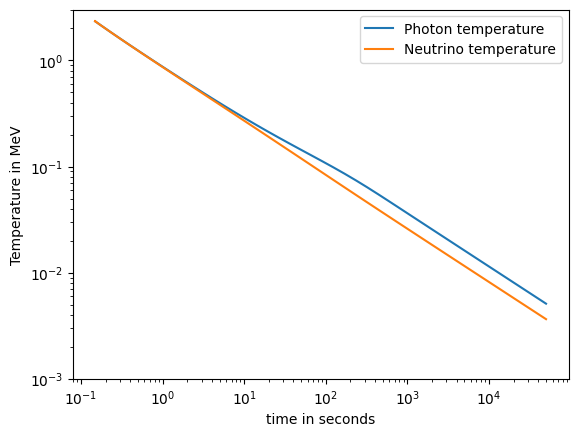

In [2]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
T_ini=27/TMeV2T9    #initial temperature in MeV
e_mass=0.51099895   #electron mass in MeV
z_ini=e_mass/T_ini

def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV

rho_b_ini=M_u*eta_ini*n_gamma_ini    #initial baryon density

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini#+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)#+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)#+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


#Derivatives for Jacobian

def dadT(T,a):
    return -((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))*a/3

def drho_nu(T,a): #neutrina energy density
    return -rho_nu_ini*4/a**5

def drho_b(T,a):
    return -h_ini*T_ini**3*3/a**4

def rho_totdT(T,a): #total density
    return drho_e(T)+drho_gamma(T)+(drho_nu(T,a))#+drho_b(T,a))*dadT(T,a)

def rho_totda(T,a): #total density
    return (drho_e(T)+drho_gamma(T))/dadT(T,a)+drho_nu(T,a)#+drho_b(T,a)



def HdT(T,a):   #Hubble parameter deriv with respect to Temperature
    return 4*np.pi/3*G*rho_totda(T,a)/H(T,a)

def Hda(T,a):   #Hubble parameter deriv with respect to Scale factor
    return 4*np.pi/3*G*rho_totdT(T,a)/H(T,a)

def dadtda(t,T,a):
    return H(T,a)+a*Hda(T,a)


def dadtdT(t,T,a):
    return dadT(T,a)*H(T,a)+a*HdT(T,a)



t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure


n_bparams=2


<Figure size 640x480 with 0 Axes>

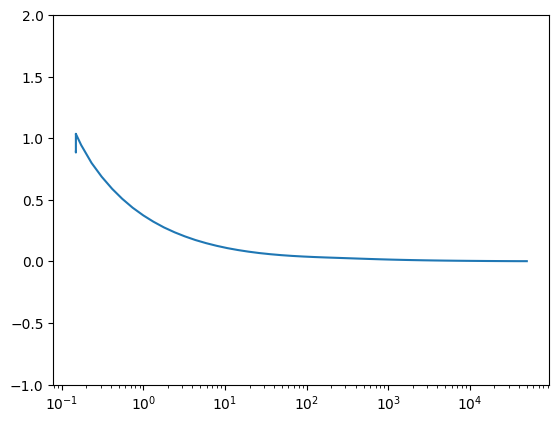

In [3]:
#test of numerical to analytical gradients


#dadtda(t,T,a)

a=sol.y[1]
T=sol.y[0]

rho_totdT(T_ini,a)

dB2 = np.gradient(a, t_space)

fig2=plt.figure()

#plt.ylim([-1,2])
#print(dB2)
#print(dB2(0.5))

#plt.plot(t_space/timeunit,dadt(t_space,T,a)/dB2)
#plt.plot(T,1/a)
#plt.plot(z,dB2,'--')


#z=np.linspace(0,0.1,10000)
'''
dB2 = np.gradient([ dadT(T2,a) for T2 in T], T)

fig2=plt.figure()

plt.ylim([-1,2])
#print(dB(0.5))
#print(dB2(0.5))

plt.plot(t_space/timeunit,[drho_e(T2) for T2 in T]/dB2)
'''


dB2 = np.gradient(a, T)

fig2=plt.figure()

plt.ylim([-1,2])
#print(dB(0.5))
#print(dB2(0.5))

plt.plot(t_space/timeunit,dadT(T,a)/dB2)

plt.xscale('log')

#print([rho_e(T2) for T2 in T])




In [4]:
import bbn2_test_integrate as bbn_n
#import He4_test_integrate as He4_n


In [5]:
2.01410177784  *M_u-2*M_u-13.135825

-0.00010211432566009648

In [6]:
#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]
print()

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(A,L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(A,L), key=lambda pair: pair[0])])
#print([label for _, label in sorted(zip(A, Y_labels))])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


print(Alter_Yl)
print(Altersort(Y_labels))

print(Y_labels)
print(PNAsort(Alter_Yl))


['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']


In [7]:
#Initial conditions for Y
#mass of various nuclei converted to MeV
m_n  =  1.0086649159  *M_u
m_p  =  1.00782503190 *M_u
m_d  =  2.01410177784 *M_u
m_t  =  3.01604928132 *M_u
m_He3 = 3.01602932197 *M_u
m_He4 = 4.00260325413 *M_u
m_Li6 = 6.0151228874  *M_u
m_Li7 = 7.016003434   *M_u

m_Be7 = 7.01692871    *M_u

nNucs=bbn_n.nnuc

Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u-Alter_mass_excess[i] for i in range(nNucs)]


Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
A=np.array(PNAsort(Alter_A))[0:nNucs]


m_Nucs = np.array(PNAsort(Alter_mass))

def rho_bY_cgs(y):
    return sum(m_Nucs*y[n_bparams:])*eta_ini*n_gamma_ini/y[1]**3*gcm3

#equilibrium ratios for simple rates #Pebbles
def G_np(T,a):

    N=eta_ini*n_gamma_ini/a**3 #number density
    return 4/3*(m_n*m_p*T/(2*np.pi*m_d))**1.5/N*np.exp((m_d-m_n-m_p)/T)

def G_nHe3(T):
    return 9/4*(m_d**2/(m_He3*m_n))**1.5*np.exp((m_n+m_He3-2*m_d)/T)

def G_tp(T):
    return 9/4*(m_d**2/(m_t*m_p))**1.5*np.exp((m_p+m_t-2*m_d)/T)  

def G_tp_nHe3(T):
    return ((m_He3*m_n)/(m_t*m_p))**1.5*np.exp((m_p+m_t-(m_n+m_He3))/T)

def G_nHe4(T):
    return 3*((m_d+m_t)/(m_He4*m_n))**1.5*np.exp((m_He4+m_n-m_d-m_t)/T)  

#Initial conditions

Y_ini=np.zeros(nNucs)+1e-50
#Y_ini=np.array([1e-20 for i in range(nNucs)])

Xn_ini = 1/(np.exp(Q/T_ini)+1)

#Initial condition based on thermal equilibrium amongst in the most important reactions

Y_ini[0] = Xn_ini        #Set initial neutron mass fraction
Y_ini[1] = 1 - Xn_ini    #Set initial proton mass fraction
Y_ini[2] = Y_ini[0]*Y_ini[1]/G_np(T_ini,1)          #Set initial deuterium mass fraction
Y_ini[3] = Y_ini[2]**2/Y_ini[1]/G_tp(T_ini)
Y_ini[4] = Y_ini[2]**2/Y_ini[0]/G_nHe3(T_ini)
#Y_ini[5] = Y_ini[2]*Y_ini[3]/Y_ini[0]/G_nHe4(T_ini)
print(Y_ini)



#compile rhs
bbn_n.rhs(t_ini/timeunit, Y_ini,rho_bY_cgs([T_ini,1]+list(Y_ini)), T_ini*TMeV2T9*1e9)

dYdt_ini=lambda Y : bbn_n.rhs(t_ini/timeunit, Y ,rho_bY_cgs([T_ini,1]+list(Y)), T_ini*TMeV2T9*1e9)

#Find initial conditions from rhs
Y_initial=opt.fsolve(dYdt_ini, x0=Y_ini)

#use these initial conditions. Currently won't converge
#Y_ini[5:]=abs(Y_initial/sum(Y_initial))[5:]
#rhs(t, Y, rho, T):
#Y_ini[6]=abs(Y_initial/sum(Y_initial))[6]*0.9
#Y_ini[8]=abs(Y_initial/sum(Y_initial))[8]*0.9

print(abs(Y_initial/sum(Y_initial)))
print(sum(Y_initial))
print(dYdt_ini(Y_ini))



[3.64536614e-01 6.35463386e-01 1.00941251e-12 2.61568971e-24
 3.28785481e-24 1.00000000e-50 1.00000000e-50 1.00000000e-50
 1.00000000e-50 1.00000000e-50]
[3.64487368e-01 6.35512632e-01 1.01623606e-12 3.74605183e-24
 1.49666085e-23 1.34300758e-11 2.38431344e-25 3.93085610e-28
 3.63978203e-34 2.28895136e-25]
1.000447878181795
[-1.05146309e+03 -1.05145125e+03  1.05145717e+03  6.01259897e-11
  5.26051538e-11  2.13211755e-19  8.65399119e-36 -6.96070473e-32
 -1.30023291e-33 -4.12484842e-33]


In [8]:
#Combining background and network



        # enumeration for different isotopes
        #  0   1   2   3    4     5     6     7     8
'''
step=20
print(solY.t[step]/timeunit)
print(solY.y.T[step])
initial_param=solY.y.T[step]
t_range=[solY.t[step],5e4*timeunit]
'''
initial_param=[T_ini,1]+list(Y_ini)
t_range=[0,5e4*timeunit]

n_params=nNucs+n_bparams
sparcity=None#np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0
def ndbackground(t,y):   #solve h and T, y[0] = T, y[1] = h and y[2] = a
    return [dTdt(t,*y),dadt(t,*y)]

def ndall(t,y):   #solve h and T, y[0] = T and y[1] = a   
    #print(ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],eta_ini*n_gamma_ini/y[2]**3*m_p*gcm3, y[0]*TMeV2T9*1e9)/timeunit))
                     
    return ndbackground(t,y[:n_bparams])+list( bbn_n.rhs(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit)



In [9]:
#solving with analytic jacobian




def jacY_anal(t,y):
    return bbn_n.jacobian(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit

def jacfun(t,x):
    return np.array([ndall(t,row)  for row in x.T]).T

Factor=None
def jacobian(t,y):
    '''
    global Factor
    jac_rhs_value=np.array(ndall(t,y))
    jactest=jacpack.num_jac(jacfun,t,y,jac_rhs_value,1e-30,Factor)
    Factor=jactest[1]
    jactest[0][:,:] = np.zeros((n_params,n_params))
    jactest[0][2:,:] = np.zeros((nNucs,n_params))
    jactest[0][:,2:] = np.zeros((n_params,nNucs))
    jactest[0][2:,2:]=jacY_anal(t,y)
    
    
    return jactest[0]
    '''
    #print(np.shape(y))
    jac=np.append(np.zeros((nNucs,n_bparams)),jacY_anal(t,y),axis=1)
    return np.append(np.zeros((n_bparams,n_params)),jac,axis=0)
    
    
    

jacsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-40,rtol=1e-4,jac=jacobian)#,t_eval=t_space)

print(jacsolY.message)
print(jacsolY.nfev)
print(jacsolY.njev)
print(jacsolY.nlu)

abun=[abun[-1] for abun in jacsolY.y[n_bparams:]]


print([abun[0],abun[1],2*abun[2],3*abun[3],3*abun[4],4*abun[5]])
print('sum: ', sum(np.array(abun)*A))

The solver successfully reached the end of the integration interval.
6603
350
1142
[7.546076591531077e-11, 0.75280018723911, 3.85723103988247e-05, 1.87140673377725e-07, 2.3382398920222997e-05, 0.24713766838975074]
sum:  1.0000000000020874


In [10]:
#Solving without jacobian

nsolY = integrate.solve_ivp(ndall, t_range, initial_param,method='Radau',atol=1e-80,rtol=1e-4)#,t_eval=t_space)
jacabun=abun
print(np.array(abun)/np.array(jacabun))
nojacabun=[abun[-1] for abun in nsolY.y[n_bparams:]]
print([nojacabun[0],nojacabun[1],2*nojacabun[2],3*nojacabun[3],3*nojacabun[4],4*nojacabun[5]])
print('sum: ',nojacabun[0]+nojacabun[1]+2*nojacabun[2]+3*nojacabun[3]+3*nojacabun[4]+4*nojacabun[5])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[7.546065049153899e-11, 0.7528001869592926, 3.857231734602633e-05, 1.8714060709341582e-07, 2.338239817528141e-05, 0.24713766932587106]
sum:  0.9999999982167527


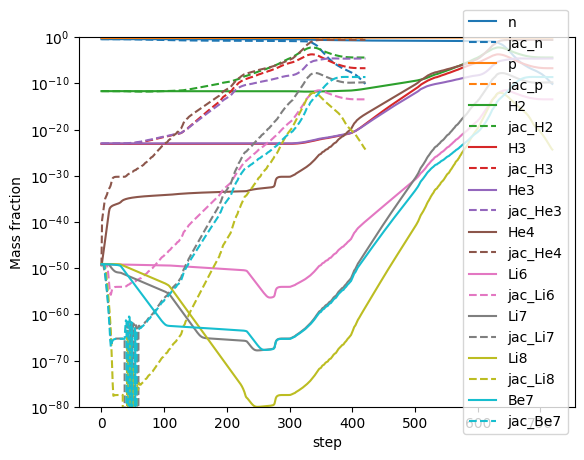

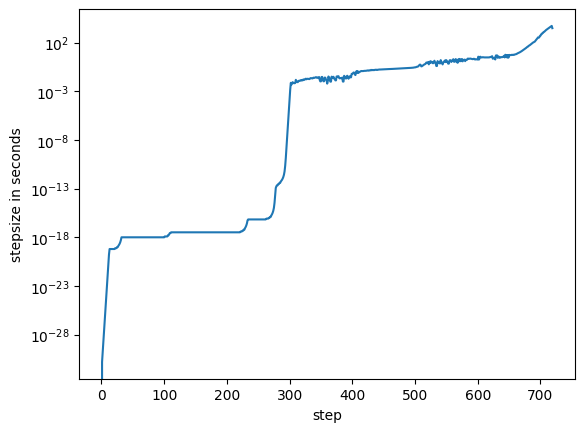

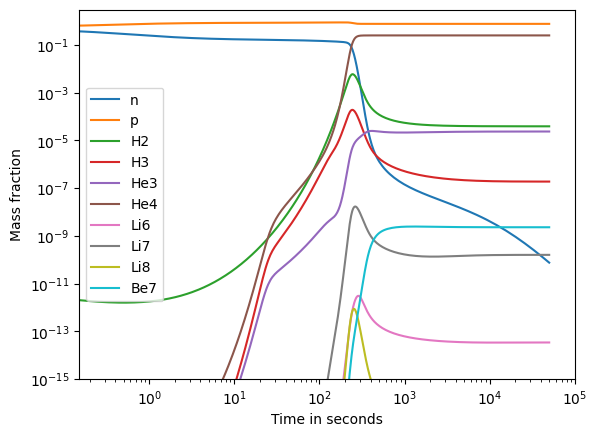

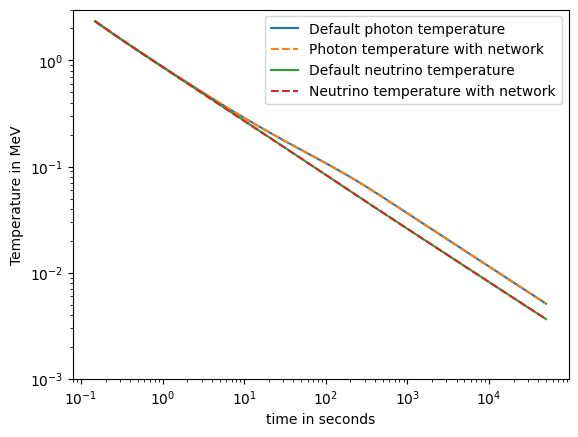

In [11]:
# Plot the results
soltime=(nsolY.t+t_ini)/timeunit   
jac_soltime=(jacsolY.t+t_ini)/timeunit   
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(nNucs):
    plt.plot(range(len(soltime)), A[i]*nsolY.y[n_bparams+i],color=colors[i], label=Y_labels[i])
    plt.plot(range(len(jac_soltime)), A[i]*jacsolY.y[n_bparams+i],'--', color=colors[i], label='jac_'+Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()

plt.figure('step size')
plt.plot(range(len(soltime)),[(nsolY.t[i]-nsolY.t[i-1])/timeunit for i in range(len(soltime))] )
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')
'''
for i in range(nNucs):
    plt.plot(soltime, A[i]*nsolY.y[n_bparams+i],color=colors[i], label=Y_labels[i])
    plt.plot(jac_soltime, A[i]*jacsolY.y[n_bparams+i],'--', color=colors[i], label='jac_'+Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-80,1e-30)
plt.xlim(t_ini/timeunit*0.9,0.4)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()
'''

plt.figure('abundance')
for i in range(nNucs):
    plt.plot(jac_soltime, A[i]*jacsolY.y[n_bparams+i], color=colors[i], label=Y_labels[i])

plt.xlabel('Time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-15,3)
plt.xlim(t_ini/timeunit,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()



plt.figure('temperature')

# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Default photon temperature')
plt.plot(soltime, nsolY.y[0],'--', label='Photon temperature with network')

# Test with completely radiation dominated universe
#t_space=solY.t
#T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(sol.t/timeunit, T_ini/sol.y[1], label='Default neutrino temperature')
plt.plot(soltime, T_ini/nsolY.y[1],'--', label='Neutrino temperature with network')

#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()


In [12]:
#Print results

print('Yp  '+'\t\t'+\
'H2/H '+'\t\t'+\
'H3/H '+'\t\t'+\
'Li7/H '+'\t\t'+\
'Li6/H '+'\t\t'+\
'Be7/H ')

print("{:.3e}".format(4*abun[5])+'\t'+\
"{:.3e}".format(abun[2]/abun[1])+'\t'+\
"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t'+\
"{:.3e}".format((abun[7]+abun[8])/abun[1])+'\t'+\
"{:.3e}".format((abun[6])/abun[1])+'\t'+\
"{:.3e}".format((abun[8])/abun[1]))

Yp  		H2/H 		H3/H 		Li7/H 		Li6/H 		Be7/H 
2.471e-01	2.562e-05	1.044e-05	3.033e-11	7.583e-15	7.688e-26


In [13]:
#find alterbbn abundance
result = subprocess.run(["/home/hansbdein/Speciale/alterbbn_v2.2/alter_eta.x", str(eta)], capture_output=True)

In [14]:
#compare to Alterbbn abundance
print('Observational values')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H ')
print('value:\t 2.450e-01 \t 2.569e-05 \t 1.1e-05 \t 1.6e-10')
print(' +/-  \t 0.030e-01  \t 0.027e-05 \t 0.2e-05 \t 0.3e-10')

print(' ')
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


print(' ')
print('Results from Alterbbn, with theoretical uncertainties:')
for info in result.stdout.decode("utf-8").split('\n')[8:11]:
    print(info)
    #print('lmao')

alterbbn_abun=np.array([float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i]) for i in range(1,7)])

reorderabun=[4*abun[5],abun[2]/abun[1],(abun[3]+abun[4])/abun[1],(abun[7]+abun[9])/abun[1],(abun[6])/abun[1],(abun[9])/abun[1]]

ratio_Str='ratio:'
for i in range(6):
    ratio_Str+='\t '+ '{:g}'.format(float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i+1])/reorderabun[i])
print(' ')
print('ratio of this code to ALterbbn results:')
print(ratio_Str)

Observational values
	 Yp  		 H2/H 		 H3/H 		 Li7/H 
value:	 2.450e-01 	 2.569e-05 	 1.1e-05 	 1.6e-10
 +/-  	 0.030e-01  	 0.027e-05 	 0.2e-05 	 0.3e-10
 
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.471e-01	 2.562e-05	 1.044e-05	 4.645e-10	 7.583e-15	 4.342e-10
 
Results from Alterbbn, with theoretical uncertainties:
	 Yp		 H2/H		 He3/H		 Li7/H		 Li6/H		 Be7/H
value:	 2.473e-01	 2.435e-05	 1.031e-05	 5.466e-10	 1.073e-14	 5.180e-10
 +/- :	 3.209e-04	 9.779e-07	 1.776e-07	 4.427e-11	 1.073e-14	 4.371e-11
 
ratio of this code to ALterbbn results:
ratio:	 1.00066	 0.950458	 0.98789	 1.17674	 1.41494	 1.19307


In [15]:
#baseabun=abun
#np.array(baseabun)/np.array(abun)

In [16]:
#test of analytical jacobian

jacvalues=nsolY.y[:,255]

jac_rhs_value=np.array(ndall(1,jacvalues))
'''
jactest1=jacpack.num_jac(jacfun,t_ini,initial_param,rhs_value_ini,1e-30,None)
print(jactest1)
jactest2=jacpack.num_jac(jacfun,t_ini,initial_param,rhs_value_ini,1e-30,jactest1[1])
print(jactest2)
'''


#sparcity=np.zeros((n_params,n_params))+1
#sparcity[:3,3:]=0
#sparcity[n_bparams:,:n_bparams]=0

Factor=None
for i in range(6):
    
    jactest=jacpack.num_jac(jacfun,t_ini,jacvalues,jac_rhs_value,1e-30,Factor)
    if Factor is not None:
        print(Factor-jactest[1])
    Factor=jactest[1]
print(jactest[0][2:,2:]*timeunit)

[1.34110451e-09 1.34110451e-09 1.34110451e-09 1.34110451e-09
 1.34110451e-09 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.34110451e-09 1.34110451e-09 1.34110451e-09 1.34110451e-09]
[1.34110451e-10 1.34110451e-10 1.34110451e-10 1.34110451e-10
 1.34110451e-10 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.34110451e-10 1.34110451e-10]
[1.34110451e-11 1.34110451e-11 1.34110451e-11 1.34110451e-11
 1.34110451e-11 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.34110451e-11 0.00000000e+00]
[0.00000000e+00 1.26807151e-12 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.26807151e-12 0.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-6.69170448e+05 -4.60037489e+05  1.76046743e+17  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00 -0.00000000e+00]
 [-6.69040453e+05 -4.60112051e+05  1.76046743e+17  0.000000

In [17]:
#test of analytical jacobian
jac=bbn_n.jacobian(t_ini/timeunit, jacvalues[2:],eta_ini*n_gamma_ini/jacvalues[1]**3*m_p*gcm3, jacvalues[0]*TMeV2T9*1e9)
#np.append(np.zeros((nNucs,n_bparams)),jac,axis=1)
print(jac)
print((jactest[0][2:,2:]*timeunit)/jac)#*timeunit)

[[-4.98352075e+05 -2.85794391e+05  1.76055347e+17  3.11868945e+15
  -1.36791116e+10  1.44328709e+12  5.67920258e+15  6.20951362e+14
   1.30023291e+17 -2.16295096e+09]
 [-4.98199244e+05 -2.85882044e+05  1.76055347e+17 -1.71723472e+10
   2.72603810e+15  2.55637022e+08  5.67871667e+15 -1.21525033e+09
  -2.26224639e+08  6.13741797e+15]
 [ 4.98275659e+05  2.85838217e+05 -1.76055347e+17  3.11867232e+15
   2.72602445e+15  8.48266794e+07  2.13291524e+14  1.15952611e+09
   9.78679199e+06  1.27637107e+09]
 [ 2.30408969e-08 -7.16257892e-14  8.27194276e+03 -3.11868947e+15
   1.36673723e+10  2.56857808e+08  7.59378179e+07  7.09010707e+18
   2.57999142e-04 -9.65147411e-15]
 [-1.24829738e-13  1.45006832e-08  9.07499069e+03  1.71579285e+10
  -2.72603811e+15  1.44328831e+12  4.85978301e+11 -1.14056529e-14
   0.00000000e+00  4.06347422e+17]
 [ 6.01295669e-19  1.05110430e-24  2.18408757e-13  2.53160993e-01
   6.58912750e+04 -1.44358697e+12  5.89298023e+15  7.09010707e+18
   4.32875696e+08  4.06347424e+17

/tmp/ipykernel_8875/2620531002.py:5: RuntimeWarning: invalid value encountered in divide
  print((jactest[0][2:,2:]*timeunit)/jac)#*timeunit)


In [18]:
#Load precise Alterbbn data
data=np.loadtxt('./Alterdata/output.txt',skiprows=2)

'''
#run Alterbbn with chosen integration routine
failsafe=12
subprocess.run(["/home/hansbdein/Speciale/alterbbn_v2.2/no_err_calc.x", str(failsafe)], capture_output=True)
data=np.loadtxt('./output.txt',skiprows=2)
'''

#"\\wsl.localhost\Ubuntu\home\hansbdein\Speciale\alterbbn_v2.2"

#remove non-time steps
prevtime=0
mask=[]
for time in data:
    if time[0]>prevtime:
        prevtime=time[0]
        mask.append(True)
    else:
        mask.append(False)


data=data[mask,...]

print(data[0,0]/1e3)
#151983983107661.34
#1.519839831076613438e+14
#2.264733810941325e+20

#change Alterbbn data for time and temperature in hbar/GeV to hbar/MeV
data[:,0]*=1e-3
data[:,1]*=1e3
data[:,2]*=1e3
#change order of isotopes to be sorted by Y rather than A
data[:,3:]=PNAsort(data[:,3:].T).T
print(t_ini)


2.2641798198795177e+20
2.264733810941325e+20


In [19]:
mask

[True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,


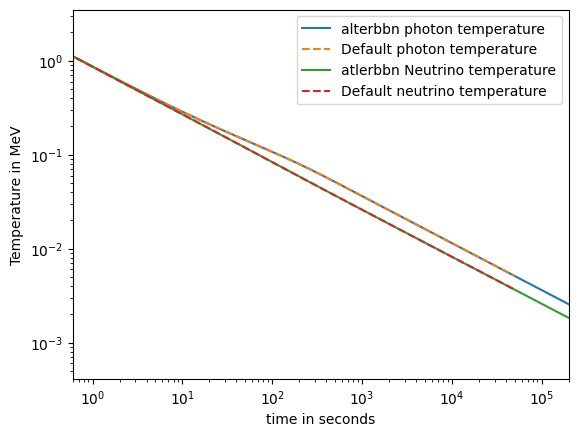

In [20]:
#compare with Alterbbn background


plt.figure('temperature')
# Plot the Temperature
plt.plot(data[:,0]/timeunit, data[:,1], label='alterbbn photon temperature')
plt.plot(sol.t/timeunit, sol.y[0],'--', label='Default photon temperature')


plt.plot(data[:,0]/timeunit, data[:,2], label='atlerbbn Neutrino temperature')
plt.plot(sol.t/timeunit, T_ini/sol.y[1],'--', label='Default neutrino temperature')
#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')


#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

plt.xlim((0.6, 2e5))
#plt.ylim((1e-3,3))

plt.legend()
plt.show()



In [21]:
#Solve With timesteps from Alterbbn
t_space=data[:,0]-data[0,0]

SolAltertime = integrate.solve_ivp(ndall, [t_space[0],t_space[-1]], initial_param,method='Radau',atol=1e-80,rtol=1e-4,jac=jacobian,t_eval=t_space)


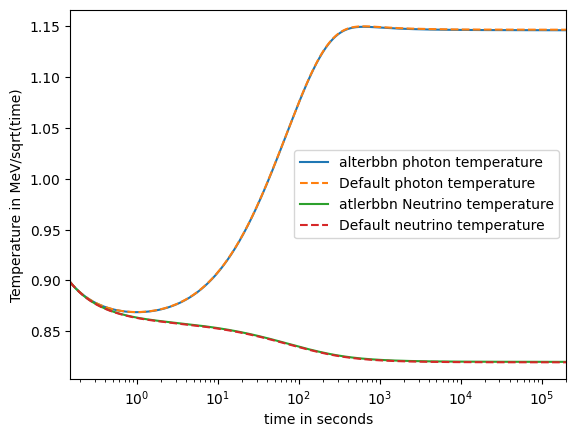

In [22]:
#compare with Alterbbn background
plt.figure('temperature')
# Plot the Temperature
plt.plot(data[:,0]/timeunit, data[:,1]*np.sqrt(data[:,0]/timeunit), label='alterbbn photon temperature')
plt.plot(data[:,0]/timeunit, SolAltertime.y[0]*np.sqrt(data[:,0]/timeunit),'--', label='Default photon temperature')


plt.plot(data[:,0]/timeunit, data[:,2]*np.sqrt(data[:,0]/timeunit), label='atlerbbn Neutrino temperature')
plt.plot(data[:,0]/timeunit, T_ini/SolAltertime.y[1]*np.sqrt(data[:,0]/timeunit),'--', label='Default neutrino temperature')
#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')


#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV/sqrt(time)')

plt.xscale('log')


plt.xlim((data[0,0]/timeunit, 2e5))
#plt.ylim((1e-3,3))

plt.legend()
plt.show()


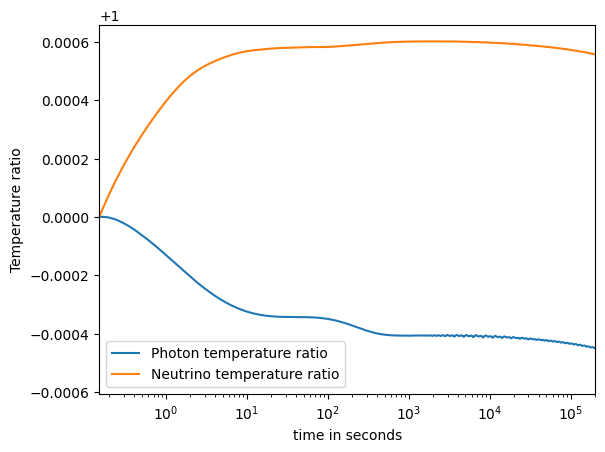

In [23]:
#compare with Alterbbn background
# Plot the Temperature
plt.plot(data[:,0]/timeunit, data[:,1]/SolAltertime.y[0], label='Photon temperature ratio')


plt.plot(data[:,0]/timeunit, data[:,2]*SolAltertime.y[1]/T_ini, label='Neutrino temperature ratio')

#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')


#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature ratio')

plt.xscale('log')


plt.xlim((data[0,0]/timeunit, 2e5))


plt.legend()
plt.show()

In [24]:
data[12002,0]/timeunit

3.8889957541193474

In [25]:
print(data[10900,1]*1000)
print(data[21800,1]*1000)



524.9395635221518
189.1648336180492


In [26]:
def find_local_maxima(arr):
    local_maxima = []
    for i in range(1, len(arr) - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            local_maxima.append(i)
    return local_maxima

He4peaks=find_local_maxima((data[:,0]/timeunit/1e2)**-10*A[5]*SolAltertime.y[n_bparams+5])
Alterpeaks=find_local_maxima((data[:,0]/timeunit/1e2)**-10*A[5]*data[:,5+3])

In [27]:
He4peaks

[153, 10879, 21787, 41312]

peak at 0.14905726268382524 seconds and 2.326679271919599 MeV 
peak at 2.7585633318286 seconds and 0.5267988880998454 MeV 
peak at 25.743939750239402 seconds and 0.18935407276593935 MeV 
peak at 244.2317251183032 seconds and 0.07261035568453153 MeV 


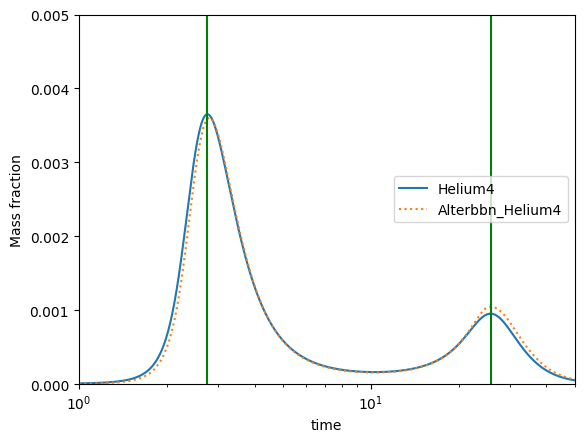

In [28]:
plt.plot(data[:,0]/timeunit, (data[:,0]/timeunit/1e2)**-10*A[5]*SolAltertime.y[n_bparams+5], label='Helium4')
plt.plot(data[:,0]/timeunit, (data[:,0]/timeunit/1e2)**-10*A[5]*data[:,5+3],':', label='Alterbbn_Helium4')
plt.xlabel('time')
plt.ylabel('Mass fraction')
plt.ylim(0,0.005)
plt.xlim(1 ,50)
plt.xscale('log')
for i in He4peaks:
    plt.axvline(data[i,0]/timeunit,color='g')
    print('peak at '+str(data[i,0]/timeunit)+' seconds and '+str(data[i,1])+' MeV ')

#plt.yscale('log')
plt.legend(loc='right')
plt.show()

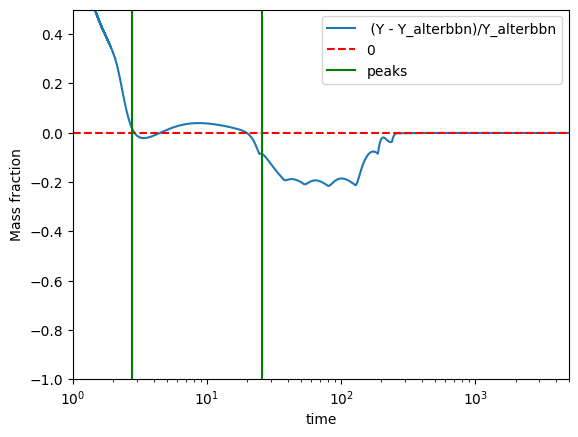

In [29]:
plt.plot(data[:,0]/timeunit, (SolAltertime.y[n_bparams+5]-data[:,5+3])/data[:,5+3], label=' (Y - Y_alterbbn)/Y_alterbbn')
#plt.plot(data[:,0]/timeunit, (data[:,0]/timeunit/1e2)**-10*A[5]*data[:,5+3],':', label='Alterbbn_Helium4')
plt.xlabel('time')
plt.ylabel('Mass fraction')
plt.axhline(0,color='r',linestyle='--',label='0')
plt.axvline(data[He4peaks[1],0]/timeunit,color='g',label='peaks')
plt.axvline(data[He4peaks[2],0]/timeunit,color='g')
plt.ylim(-1,0.5)
plt.xlim(1 ,5000)
plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()

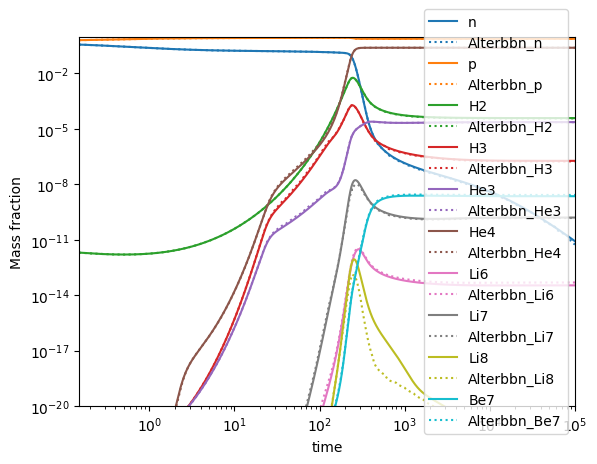

In [30]:
# Plot the results
soltime=(nsolY.t+t_ini)/timeunit   
jac_soltime=(jacsolY.t+t_ini)/timeunit   
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(10):
    plt.plot(data[:,0]/timeunit, A[i]*SolAltertime.y[n_bparams+i],color=colors[i], label=Y_labels[i])
    plt.plot(data[:,0]/timeunit, A[i]*data[:,i+3],':', color=colors[i], label='Alterbbn_'+Y_labels[i])

plt.xlabel('time')
plt.ylabel('Mass fraction')
plt.ylim(1e-20,1)
plt.xlim(t_ini/timeunit ,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()

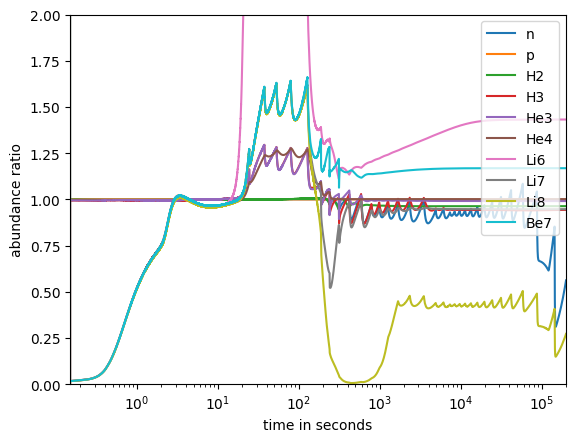

In [31]:
# Plot the results
soltime=(nsolY.t+t_ini)/timeunit   
jac_soltime=(jacsolY.t+t_ini)/timeunit   
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(nNucs):
    plt.plot(data[:,0]/timeunit, data[:,i+3]/SolAltertime.y[n_bparams+i],color=colors[i], label=Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('abundance ratio')

plt.xscale('log')


plt.xlim((data[0,0]/timeunit, 2e5))
plt.ylim(0,2)

plt.legend(loc='upper right')
plt.show()

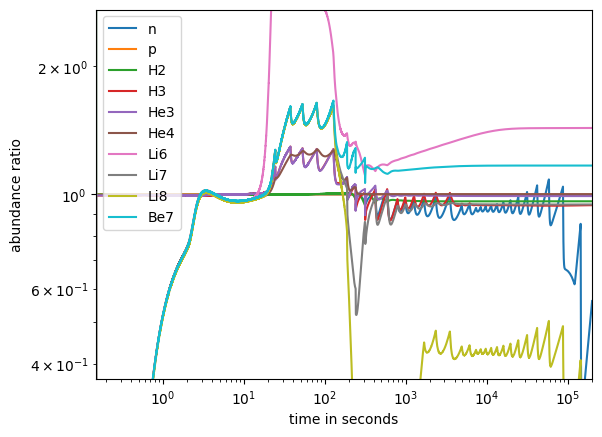

In [32]:
# Plot the results
soltime=(nsolY.t+t_ini)/timeunit   
jac_soltime=(jacsolY.t+t_ini)/timeunit   
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(nNucs):
    plt.plot(data[:,0]/timeunit, data[:,i+3]/SolAltertime.y[n_bparams+i],color=colors[i], label=Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('abundance ratio')

plt.xscale('log')
plt.yscale('log')

plt.xlim((data[0,0]/timeunit, 2e5))
plt.ylim(np.exp(-1),np.exp(1))

plt.legend()
plt.show()

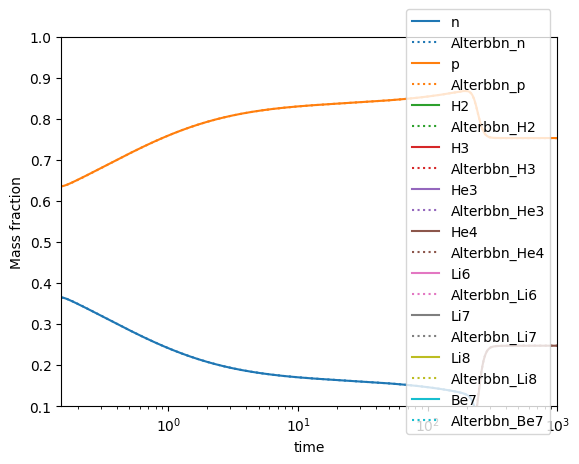

In [33]:
# Plot the results
soltime=(nsolY.t+t_ini)/timeunit   
jac_soltime=(jacsolY.t+t_ini)/timeunit   
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(nNucs):
    plt.plot(data[:,0]/timeunit, A[i]*SolAltertime.y[n_bparams+i],color=colors[i], label=Y_labels[i])
    plt.plot(data[:,0]/timeunit, A[i]*data[:,i+3],':', color=colors[i], label='Alterbbn_'+Y_labels[i])

plt.xlabel('time')
plt.ylabel('Mass fraction')
plt.ylim(1e-1,1)
plt.xlim(t_ini/timeunit ,1e3)
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc='right')
plt.show()

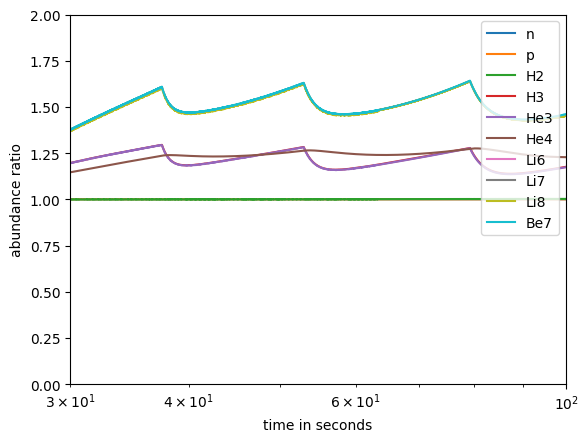

In [34]:
# Plot the results
soltime=(nsolY.t+t_ini)/timeunit   
jac_soltime=(jacsolY.t+t_ini)/timeunit   
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(nNucs):
    plt.plot(data[:,0]/timeunit, data[:,i+3]/SolAltertime.y[n_bparams+i],color=colors[i], label=Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('abundance ratio')

plt.xscale('log')


plt.xlim(30, 100)
plt.ylim(0,2)

plt.legend(loc='upper right')
plt.show()

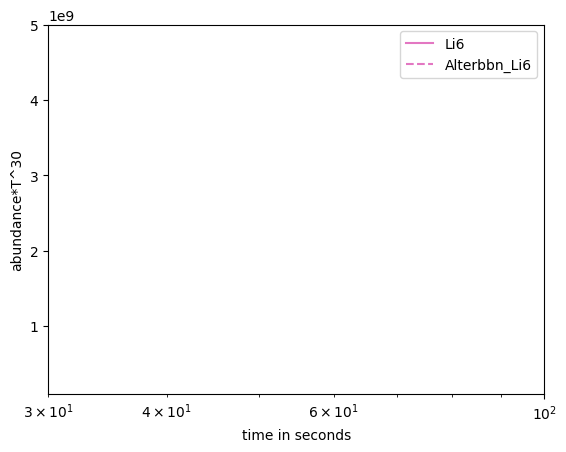

In [35]:
# Plot the results
soltime=(nsolY.t+t_ini)/timeunit   
jac_soltime=(jacsolY.t+t_ini)/timeunit   
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i in range(6,7):
    plt.plot(data[:,0]/timeunit, SolAltertime.y[n_bparams+i]*(data[:,1]*1e5)**30,color=colors[i], label=Y_labels[i])
    plt.plot(data[:,0]/timeunit, data[:,i+3]*(data[:,1]*1e5)**30,'--',color=colors[i], label='Alterbbn_'+Y_labels[i])


plt.xlabel('time in seconds')
plt.ylabel('abundance*T^30')

plt.xscale('log')
#plt.yscale('log')

plt.xlim(30, 100)
plt.ylim(1e8,5e9)

plt.legend(loc='upper right')
plt.show()

In [36]:
#finding rates that contribute to helium production
all_nuclei = ["p","n", "h2", "h3", "he3", "he4","Li6","Li7","Be7","Li8"]#,"B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]
bbn_library = reaclibrary.linking_nuclei(all_nuclei)
bbn_network = pyna.networks.PythonNetwork(libraries=bbn_library)


filter = pyna.RateFilter(products=["He4"], exact=False)
He4rates = bbn_library.filter(filter).get_rates()
He4rates

[Li6 ⟶ He4 + H2,
 Li7 ⟶ He4 + H3,
 Li8 ⟶ He4 + He4 + e⁻ + 𝜈,
 Be7 ⟶ He4 + He3,
 Li6 ⟶ n + p + He4,
 H2 + H2 ⟶ He4 + 𝛾,
 H3 + p ⟶ He4 + 𝛾,
 He3 + n ⟶ He4 + 𝛾,
 He3 + p ⟶ He4 + e⁺ + 𝜈,
 H3 + H2 ⟶ n + He4,
 He3 + H2 ⟶ p + He4,
 He3 + H3 ⟶ H2 + He4,
 Li6 + n ⟶ He4 + H3,
 Li6 + p ⟶ He4 + He3,
 Li7 + p ⟶ He4 + He4,
 Be7 + n ⟶ He4 + He4,
 H3 + H3 ⟶ n + n + He4,
 He3 + H3 ⟶ n + p + He4,
 He3 + He3 ⟶ p + p + He4,
 Li7 + H2 ⟶ n + He4 + He4,
 Li8 + p ⟶ n + He4 + He4,
 Be7 + H2 ⟶ p + He4 + He4,
 Li7 + H3 ⟶ n + n + He4 + He4,
 Li7 + He3 ⟶ n + p + He4 + He4,
 Be7 + H3 ⟶ n + p + He4 + He4,
 Be7 + He3 ⟶ p + p + He4 + He4]

In [37]:
#Function for evaluating pyna rates at a given time



def ratevalue(rate,index):
    Tpeak=data[index,1]*TMeV2T9*1e9
    value=rate.eval(Tpeak)
    for reactant in rate.reactants:
        i=3+Y_labels.index(reactant.caps_name)
        value*=data[index,i]
        

    return  value/data[index,3+Y_labels.index('He4')]





In [38]:
#Finding values of Y_He4 derivatives at the first peak
i_peak=He4peaks[1]
print(f'dlog(Y)/dt at {data[i_peak,0]/timeunit:.2f} seconds')
for rate in sorted(He4rates,key=lambda x: ratevalue(x,i_peak),reverse=True):
    print(str(ratevalue(rate,i_peak))+'\t'+rate.fname)
    #print(rate.eval(Tpeak))
    #print(rate.reactants)
    

dlog(Y)/dt at 2.76 seconds
276.33982767194755	p_t__he4
7.513956472772178	n_he3__he4
0.0002657291883075467	d_d__he4
4.168446418421614e-06	d_t__n_he4
2.9109159053381643e-06	d_he3__p_he4
1.705398581029589e-13	li6__n_p_he4
1.150263089414418e-13	li6__he4_d
4.178485932651083e-15	t_t__n_n_he4
4.306889336929117e-16	he3_he3__p_p_he4
2.5220138183483567e-16	t_he3__n_p_he4
1.5854432458601486e-16	t_he3__d_he4
1.1255007475785782e-16	p_li6__he4_he3
8.786134222515319e-17	n_li6__he4_t
7.863068157552255e-17	p_he3__he4__weak__bet_pos_
7.852582660670099e-20	li7__he4_t
2.788626306848712e-20	be7__he4_he3
3.299202578719189e-25	n_be7__he4_he4
1.2695479436164853e-25	p_li7__he4_he4
1.1560451179919241e-35	d_li7__n_he4_he4
2.7572351471064727e-36	p_li8__n_he4_he4
2.340448290962171e-36	d_be7__p_he4_he4
2.693467007619496e-44	t_li7__n_n_he4_he4
9.230681835622526e-45	li8__he4_he4__weak__wc12
8.569535872732718e-45	he3_li7__n_p_he4_he4
4.194463255048176e-45	t_be7__n_p_he4_he4
1.065646587986788e-45	he3_be7__p_p_he4_he4


In [39]:
#Finding values of Y_He4 derivatives at the second peak
i_peak=He4peaks[2]
print(f'dlog(Y)/dt at {data[i_peak,0]/timeunit:.2f} seconds')
for rate in sorted(He4rates,key=lambda x: ratevalue(x,i_peak),reverse=True):
    print(str(ratevalue(rate,i_peak))+'\t'+rate.fname)
    #print(rate.eval(Tpeak))
    #print(rate.reactants)

dlog(Y)/dt at 25.74 seconds
939.0374928133164	p_t__he4
5.908687335151336	n_he3__he4
0.022661159733220308	d_t__n_he4
0.0008780347846247833	d_he3__p_he4
0.00014763461040397544	t_t__n_n_he4
3.63071486764697e-06	t_he3__n_p_he4
2.4090447196817724e-06	t_he3__d_he4
1.1620936898495268e-07	he3_he3__p_p_he4
2.050304287128754e-09	d_d__he4
1.2508300910904758e-11	li7__he4_t
3.3545310859921136e-12	n_li6__he4_t
9.532231456639783e-13	li6__he4_d
9.456661443757706e-13	p_li6__he4_he3
2.270773206195136e-13	p_li7__he4_he4
2.068804349249316e-13	be7__he4_he3
5.629534748884864e-15	n_be7__he4_he4
4.891350598996879e-17	p_he3__he4__weak__bet_pos_
1.9731956220762684e-17	li6__n_p_he4
6.880649743665177e-21	d_li7__n_he4_he4
2.0057231580330375e-21	p_li8__n_he4_he4
9.120989222212186e-22	t_li7__n_n_he4_he4
6.330885407732558e-24	he3_li7__n_p_he4_he4
4.191496714222497e-24	d_be7__p_he4_he4
4.007062433844684e-25	t_be7__n_p_he4_he4
1.6470104614792754e-27	he3_be7__p_p_he4_he4
1.3630628565466078e-29	li8__he4_he4__weak__wc12


In [40]:

def Alter_n_he3__he4(T9):
    return (T9*905+1)*6.62

def n_he3__he4(T9):
    # he3 + n --> he4
    rate = 0.0

    # ka02n
    rate += np.exp(  9.04572 + -1.50147*T9**(1/3)
                  + 1.0*np.log(T9))
    # ka02n
    rate += np.exp(  5.51711)

    return rate

def he4__n_he3(T9):
    # he4 --> n + he3
    rate = 0.0

        # ka02n
    rate += np.exp(  33.0131 + -238.79/T9 + -1.50147*T9**(1/3)
                  + 2.5*np.log(T9))
    # ka02n
    rate += np.exp(  29.4845 + -238.79/T9
                  + 1.5*np.log(T9))
    return rate

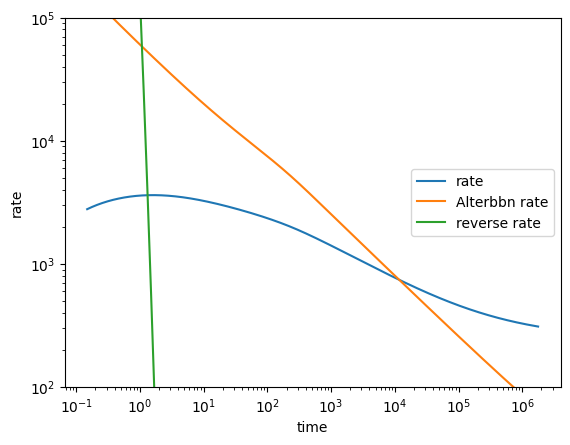

In [41]:
plt.plot(data[:,0]/timeunit, n_he3__he4(data[:,1]*TMeV2T9), label='rate')
plt.plot(data[:,0]/timeunit, Alter_n_he3__he4(data[:,1]*TMeV2T9), label='Alterbbn rate')
plt.plot(data[:,0]/timeunit, he4__n_he3(data[:,1]*TMeV2T9), label='reverse rate')
plt.xlabel('time')
plt.ylabel('rate')
plt.ylim(100,1e5)
#plt.xlim(1 ,50)
plt.yscale('log')
plt.xscale('log')

#plt.yscale('log')
plt.legend(loc='right')
plt.show()

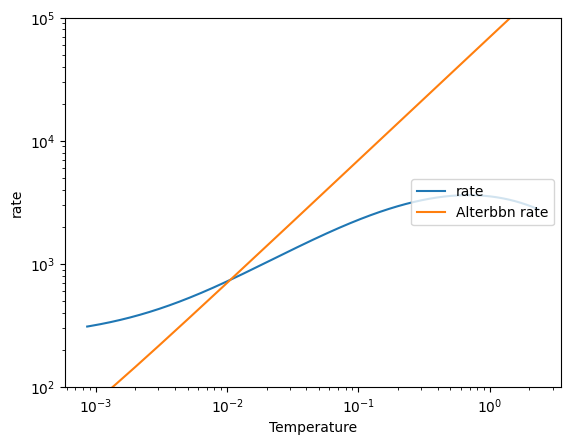

In [42]:
plt.plot(data[:,1], n_he3__he4(data[:,1]*TMeV2T9), label='rate')
plt.plot(data[:,1], Alter_n_he3__he4(data[:,1]*TMeV2T9), label='Alterbbn rate')
#plt.plot(data[:,1], he4__n_he3(data[:,1]*TMeV2T9), label='reverse rate')
plt.xlabel('Temperature')
plt.ylabel('rate')
plt.ylim(100,1e5)
#plt.xlim(1 ,50)
plt.yscale('log')
plt.xscale('log')

#plt.yscale('log')
plt.legend(loc='right')
plt.show()

In [43]:
max(0,-5)

0